In [1]:
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from requests_html import HTMLSession
from time import sleep
from datetime import datetime

In [2]:
%config InlineBackend.figure_format = "retina"

<h2 style="color:crimson">Ejercicios</h2>

1. Repite el ejemplo *Arxiv ML Papers (I)*, agrega dos nuevas columnas al DataFrame final: `Abstract`, con el resumen de cada paper; `Submitted`, con la fecha en la que fue agregado al sistema. **Hint**: Ambos elementos se encuentran dentro de la *url* encontrada.

In [3]:
class Paper:
    
    def __init__(self, title, abstract_url, abstract, submitted):
        self.title = title
        self.abstract_url = abstract_url
        self.abstract = abstract
        self.submitted = submitted
        
    def toDict(self):
        return {
            'title': self.title,
            'url': self.abstract_url,
            'abstract': self.abstract,
            'submitted': self.submitted
        }
        
class Crawler:
    
    def getPage(self, url):
        r = None
        with HTMLSession() as sess:
            r = sess.get(url)
        return r
    
    def getEntriesUrl(self, r):
        print(r)
        div_page = r.html.find("div[id='dlpage']", first=True)
        paper_list_url = None
        if div_page != None:
            entries = div_page.find("small")[-1]
            entries = entries.find("a")[-1]
            paper_list_url, *_ = entries.absolute_links
        return paper_list_url
    
    def getPapers(self, r):
        divpage = r.html.find("div[id='dlpage']", first=True)
        papers_links = divpage.find("dt")
        papers_titles = divpage.find("dd")
        values = []
        for link_secc, title_secc in zip(papers_links, papers_titles):
            title = title_secc.find("div[class='list-title mathjax']", first=True).text
            abstract_url = link_secc.find("a[title='Abstract']", first=True).absolute_links
            abstract_url, *_ = abstract_url
            crawler = Crawler()
            reader = crawler.getPage(abstract_url)
            abstract = reader.html.find("blockquote", first=True).text
            submitted = reader.html.find("div[class='dateline']", first=True).text
            values.append(Paper(title, abstract_url, abstract, submitted))
        return values
    
crawler = Crawler()

r = crawler.getPage("https://arxiv.org/list/stat.ML/recent")
entries_url = crawler.getEntriesUrl(r)
print(entries_url)

r = crawler.getPage(entries_url)
papers = crawler.getPapers(r)

df = pd.DataFrame.from_records([item.toDict() for item in papers])
df = df.assign(title=df.title.str.lstrip("Title: "))
df = df.assign(title=df.abstract.str.lstrip("Abstract: "))
df.head()

<Response [200]>
https://arxiv.org/list/stat.ML/pastweek?show=301


,abstract,submitted,title,url
0,Abstract: We derive a principled framework for...,(Submitted on 6 Dec 2019),We derive a principled framework for encoding ...,https://arxiv.org/abs/1912.03249
1,Abstract: Recent works have derived non-asympt...,(Submitted on 6 Dec 2019),Recent works have derived non-asymptotic upper...,https://arxiv.org/abs/1912.03154
2,Abstract: Stochastic Rank-One Bandits (Katarya...,(Submitted on 6 Dec 2019),"Stochastic Rank-One Bandits (Katarya et al, (2...",https://arxiv.org/abs/1912.03074
3,Abstract: Skin cancer is a major public health...,(Submitted on 6 Dec 2019),Skin cancer is a major public health problem a...,https://arxiv.org/abs/1912.03280
4,Abstract: Explaining the output of a complex m...,(Submitted on 6 Dec 2019),Explaining the output of a complex machine lea...,https://arxiv.org/abs/1912.03277


2. Por medio de la librería `requests` y el API de AlphaVantage, consigue los precios históricos de las monedas `["MXN", "EUR", "BRL", "ARS", "CHF"]` respecto al dólar (todos los precios deben estar en dólares). Crea un DataFrame con cada colúmna la moneda de referencia:

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>MXN</th>      <th>EUR</th>      <th>BRL</th>      <th>ARS</th>      <th>CHF</th>    </tr>  </thead>  <tbody>    <tr>      <th>2014-11-24</th>      <td>0.0732</td>      <td>1.2438</td>      <td>0.3920</td>      <td>0.1169</td>      <td>1.0342</td>    </tr>    <tr>      <th>2014-11-25</th>      <td>0.0731</td>      <td>1.2473</td>      <td>0.3955</td>      <td>0.1169</td>      <td>1.0370</td>    </tr>    <tr>      <th>2014-11-26</th>      <td>0.0728</td>      <td>1.2507</td>      <td>0.3995</td>      <td>0.1168</td>      <td>1.0401</td>    </tr>    <tr>      <th>2014-11-27</th>      <td>0.0726</td>      <td>1.2458</td>      <td>0.3947</td>      <td>0.1169</td>      <td>1.0363</td>    </tr>    <tr>      <th>2014-11-28</th>      <td>0.0717</td>      <td>1.2451</td>      <td>0.3891</td>      <td>0.1168</td>      <td>1.0351</td>    </tr>  </tbody></table>

In [4]:
def getCurrencies(tc=[], currencies=["MXN","EUR","BRL","ARS","CHF"]):
    params = {
        "function": "FX_DAILY",
        "to_symbol": "USD",
        "from_symbol": '',
        "apikey": "G871A3R3IT0HNMTG",
        "datatype": "csv",
        "outputsize":"full"
    }
    for currency in currencies:
        params['from_symbol'] = currency
        r =requests.get("https://www.alphavantage.co/query", params=params)
        tc.append(pd.read_csv(r.url)[["timestamp", "close"]])
        sleep(24)
    return tc

tc = getCurrencies()

In [5]:
mxn=tc[0].rename({"close":"MXN"}, axis=1)
eur=tc[1].rename({"close":"EUR"}, axis=1)
brl=tc[2].rename({"close":"BRL"}, axis=1)
ars=tc[3].rename({"close":"ARS"}, axis=1)
chf=tc[4].rename({"close":"CHF"}, axis=1)

df = mxn.merge(eur, on='timestamp', how='inner')
df = df.merge(brl, on='timestamp', how='inner')
df = df.merge(ars, on='timestamp', how='inner')
df = df.merge(chf, on='timestamp', how='inner')
df = df.sort_values(by=['timestamp'], ascending=True, na_position='first')
currency_df = df[df['timestamp'] >= '2014-11-24'].set_index("timestamp")
del currency_df.index.name
currency_df.head()

,MXN,EUR,BRL,ARS,CHF
2014-11-24,0.0732,1.2438,0.3920,0.1169,1.0342
2014-11-25,0.0731,1.2473,0.3955,0.1169,1.0370
2014-11-26,0.0728,1.2507,0.3995,0.1168,1.0401
2014-11-27,0.0726,1.2458,0.3947,0.1169,1.0363
2014-11-28,0.0717,1.2451,0.3891,0.1168,1.0351


3. Con el DataFrame creado en el ejercicio 2, crea el siguiente mapa de calor con la correlación entre cada una de las monedas. **hint**: Revisa que métodos tiene un DataFrame para crear correlaciones; considera la librería `seaborn`.

![](../files/lec04/imgs/heatmap.png)

---

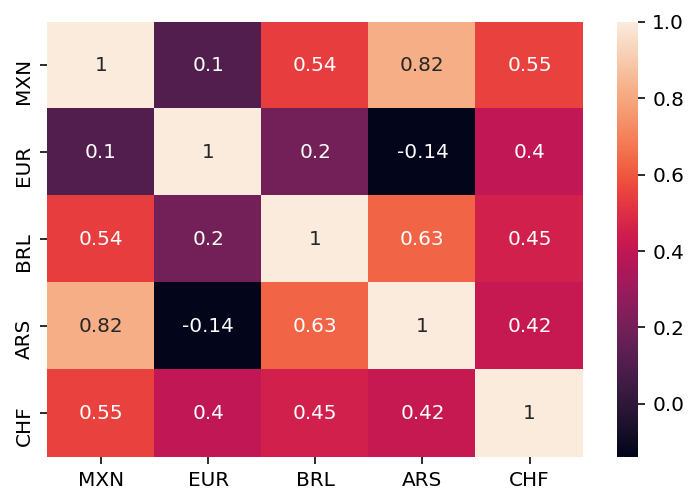

In [6]:
sns.heatmap(currency_df.corr(), annot=True)

4. Con el DataFrame creado en el ejercicio 2, crea un nuevo DataFrame que incluya una correlación móvil con ventana de 30 días de cada una de las monedas respecto a `"MXN"`. **hint**: Investiga sobre el método `.xs` de un DataFrame

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>EUR</th>      <th>BRL</th>      <th>ARS</th>      <th>CHF</th>    </tr>  </thead>  <tbody>    <tr>      <th>2015-03-19</th>      <td>0.900941</td>      <td>0.870440</td>      <td>0.835029</td>      <td>0.916637</td>    </tr>    <tr>      <th>2015-03-20</th>      <td>0.874866</td>      <td>0.815453</td>      <td>0.762308</td>      <td>0.903594</td>    </tr>    <tr>      <th>2015-03-22</th>      <td>0.866783</td>      <td>0.789977</td>      <td>0.726098</td>      <td>0.900547</td>    </tr>    <tr>      <th>2015-03-23</th>      <td>0.835823</td>      <td>0.728781</td>      <td>0.643129</td>      <td>0.885424</td>    </tr>    <tr>      <th>2015-03-24</th>      <td>0.801267</td>      <td>0.671188</td>      <td>0.560149</td>      <td>0.877682</td>    </tr>  </tbody></table>

---

In [7]:
corr_df = df[df['timestamp'] >= '2015-03-19'].set_index("timestamp")
corr_df = corr_df.rolling(window=30, center=True).corr(corr_df["MXN"])
corr_df = corr_df.reset_index()
corr_df = corr_df[corr_df["MXN"]>0]
corr_df = corr_df.set_index(["MXN","timestamp"])
corr_df.head()

EUR       BRL       ARS       CHF
MXN timestamp                                         
1.0 2015-04-06  0.610917 -0.194172  0.530950  0.158749
    2015-04-07  0.591222 -0.302115  0.597438  0.085758
    2015-04-08  0.559159 -0.327447  0.608217  0.077725
    2015-04-09  0.527217 -0.381337  0.645636  0.037102
    2015-04-10  0.463174 -0.402200  0.625505  0.024672

5. Con el DataFrame creado en el ejercicio 4, crea la siguiente figura con _scatterplots_ entre todas las combinaciones de las correlaciones respecto a `"MXN"`. ¿Encuentras algún patrón en alguna combinación?

![](../files/lec04/imgs/scatter.png)

---

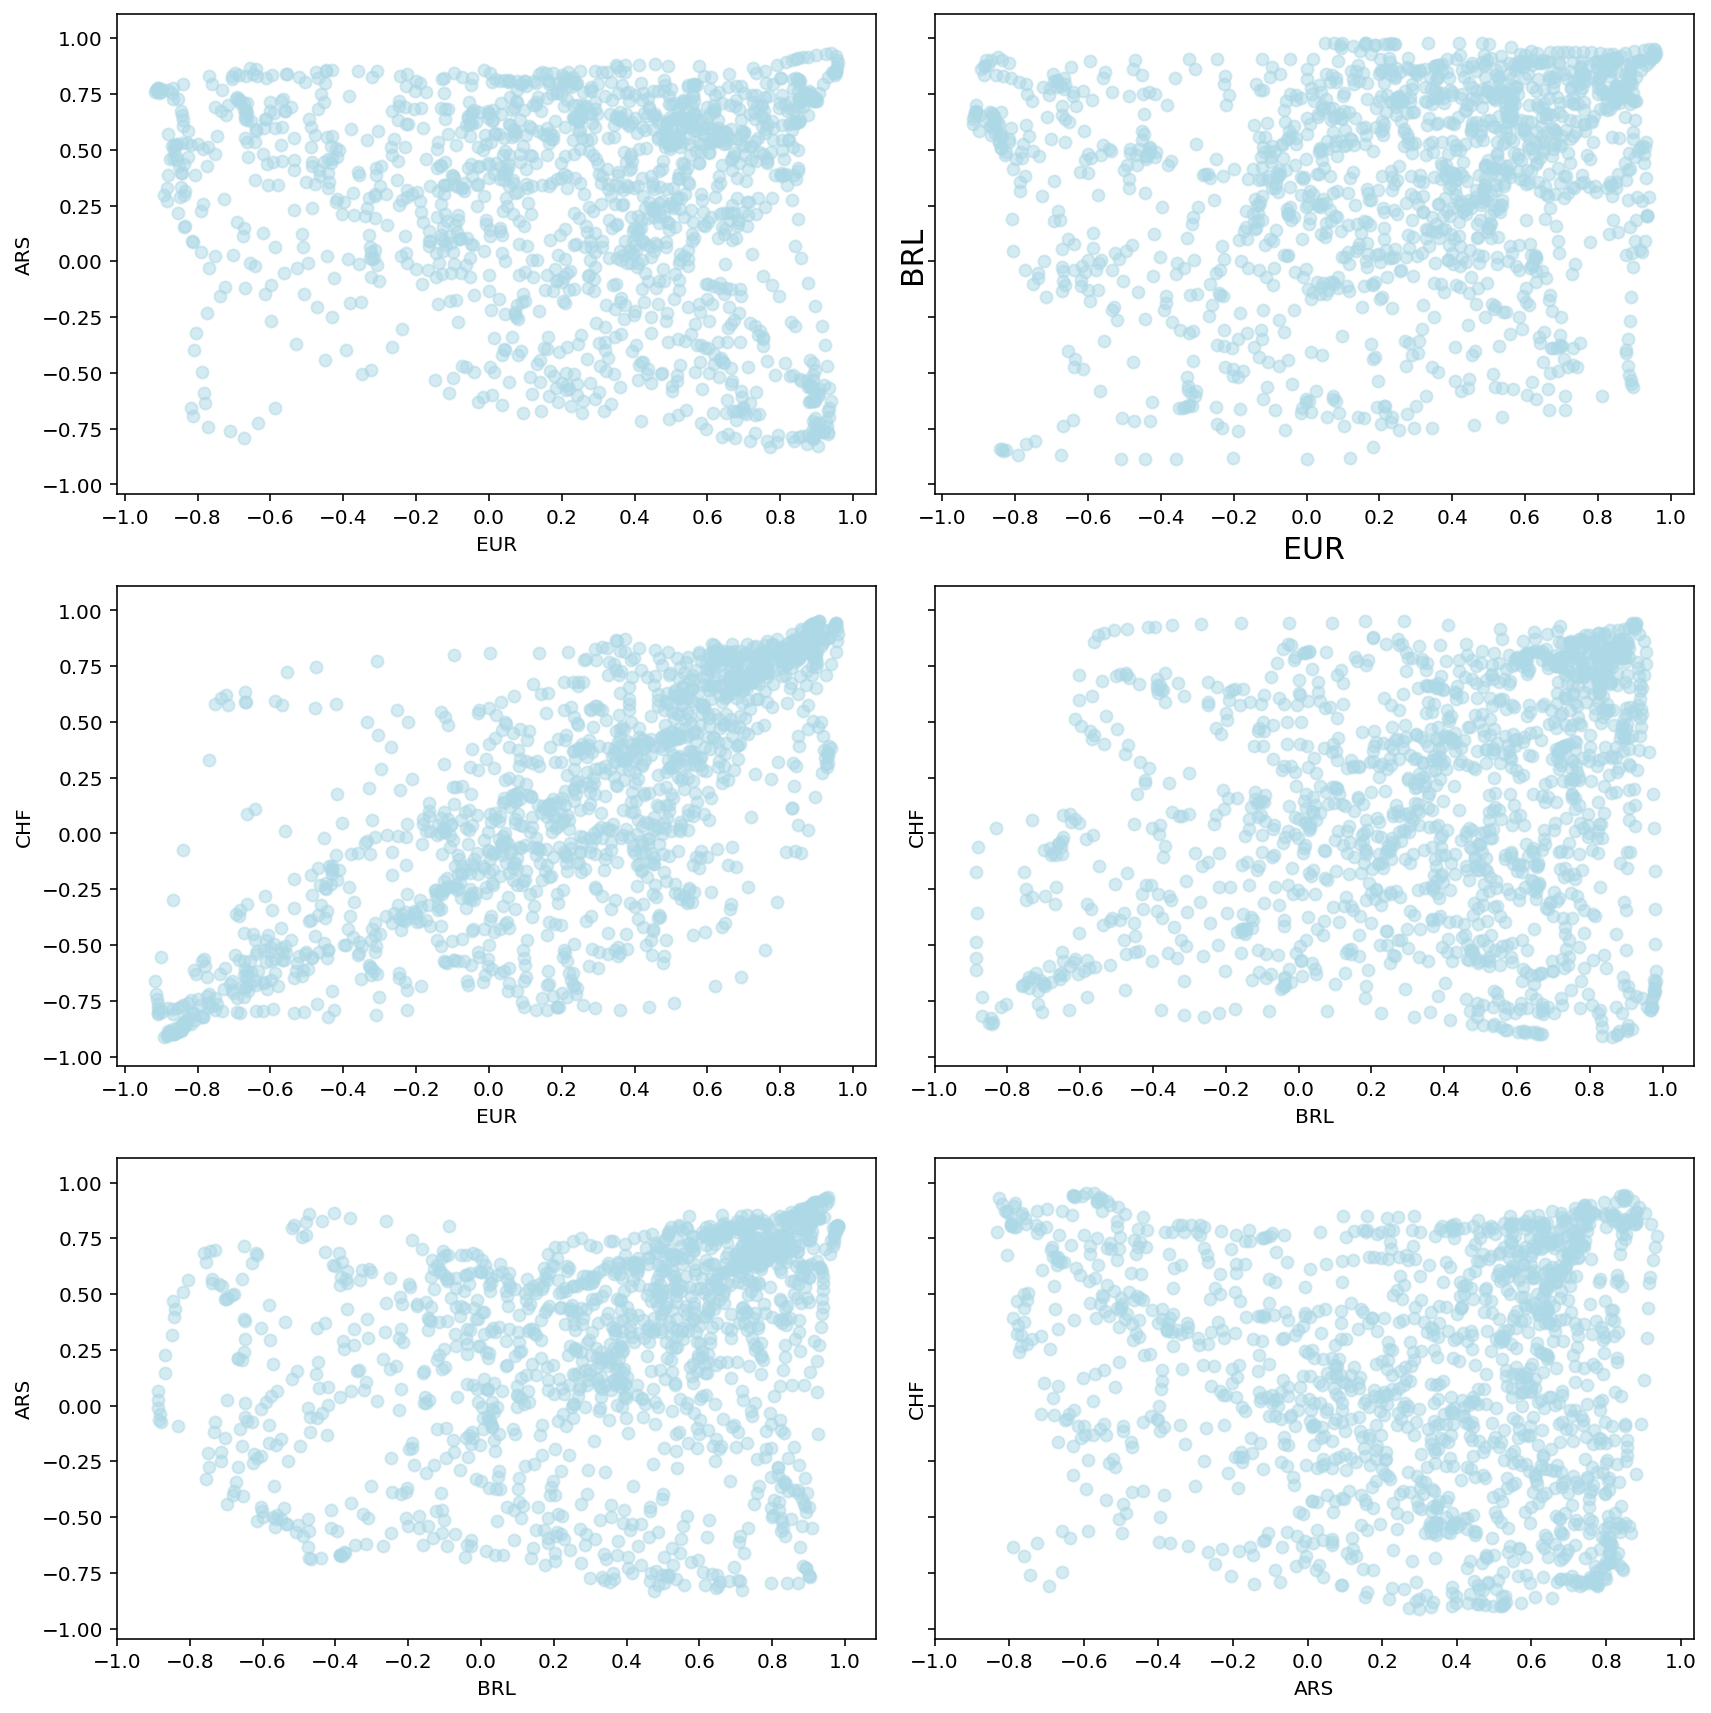

In [8]:
fig, axs = plt.subplots(3, 2, figsize=(12,12),sharey=True,tight_layout=True)

axs[0,0].scatter(corr_df["EUR"],corr_df["ARS"],marker="o",alpha=.5,c="lightblue")
axs[0,0].set(xlabel='EUR', ylabel='ARS')
axs[0,0].xaxis.set_ticks(np.arange(-1,1.2,.2))
axs[0,0].xaxis.get_label().set_fontsize(10)
axs[0,0].yaxis.get_label().set_fontsize(10)

axs[0,1].scatter(corr_df ["EUR"],corr_df["BRL"],marker="o",alpha=.5,c="lightblue")
axs[0,1].set(xlabel='EUR', ylabel='BRL')
axs[0,1].xaxis.set_ticks(np.arange(-1,1.2,.2))
axs[0,1].xaxis.get_label().set_fontsize(15)
axs[0,1].yaxis.get_label().set_fontsize(15)

axs[1,0].scatter(corr_df["EUR"],corr_df["CHF"],marker="o",alpha=.5,c="lightblue")
axs[1,0].set(xlabel='EUR', ylabel='CHF')
axs[1,0].xaxis.set_ticks(np.arange(-1,1.2,.2))
axs[1,0].xaxis.get_label().set_fontsize(10)
axs[1,0].yaxis.get_label().set_fontsize(10)

axs[1,1].scatter(corr_df["BRL"],corr_df["CHF"],marker="o",alpha=.5,c="lightblue")
axs[1,1].set(xlabel='BRL', ylabel='CHF')
axs[1,1].xaxis.set_ticks(np.arange(-1,1.2,.2))
axs[1,1].xaxis.get_label().set_fontsize(10)
axs[1,1].yaxis.get_label().set_fontsize(10)

axs[2,0].scatter(corr_df["BRL"],corr_df["ARS"],marker="o",alpha=.5,c="lightblue")
axs[2,0].set(xlabel='BRL', ylabel='ARS')
axs[2,0].xaxis.set_ticks(np.arange(-1,1.2,.2))
axs[2,0].xaxis.get_label().set_fontsize(10)
axs[2,0].yaxis.get_label().set_fontsize(10)

axs[2,1].scatter(corr_df["ARS"],corr_df["CHF"],marker="o",alpha=.5,c="lightblue")
axs[2,1].set(xlabel='ARS', ylabel='CHF')
axs[2,1].xaxis.set_ticks(np.arange(-1,1.2,.2))
axs[2,1].xaxis.get_label().set_fontsize(10)
axs[2,1].yaxis.get_label().set_fontsize(10)

plt.show()

6. Con el DataFrame creado en el ejercicio 4, crea la siguiente figura, la cuál representa, a cada observación, la correlación promedio entre todas las monedas respecto a `"MXN"` y unas bandas que representan la correlación máxima y mínima a cada observación.

![](../files/lec04/imgs/corr_ts.png)

## References


* https://developer.mozilla.org/en-US/docs/Web
* https://www.w3schools.com/tags/ref_httpmethods.asp